# Spam Detection

## Colab Link


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

import matplotlib.pyplot as plt

## Part 1. Data Cleaning

We will be using the "SMS Spam Collection Data Set" available at http://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

There is a link to download the "Data Folder" at the very top of the webpage. Download the zip file, unzip it, and upload the file `SMSSpamCollection` to Colab.    

### Part (a)

Open up the file in Python, and print out one example of a spam SMS, and one example of a non-spam SMS.

What is the label value for a spam message, and what is the label value for a non-spam message?

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
file_directory='/content/drive/My Drive/Colab Notebooks/APS360/Lab 5/smsspamcollection/SMSSpamCollection'

my_file = open(file_directory, "r")

count=0
for i in my_file:
  if count<=10:
    print(i)
    count+=1

my_file.close()

ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...

ham	Ok lar... Joking wif u oni...

spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's

ham	U dun say so early hor... U c already then say...

ham	Nah I don't think he goes to usf, he lives around here though

spam	FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv

ham	Even my brother is not like to speak with me. They treat me like aids patent.

ham	As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune

spam	WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only

In [ ]:
#print out one example of a non-spam SMS:
my_file = open(file_directory, "r")

for i in my_file:
  if i[0:3]=='ham':
    print(i)
    break

my_file.close()

ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...



In [ ]:
#print out one example of a spam SMS:
my_file = open(file_directory, "r")

for i in my_file:
  if i[0:4]=='spam':
    print(i)
    break

my_file.close()

spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's



**Answer:**

Label value of a spam SMS: "spam"

Label value of a non-spam SMS: "ham"

### Part (b)

How many spam messages are there in the data set?
How many non-spam messages are there in the data set?


In [ ]:
my_file = open(file_directory, "r")
count_1=0
for i in my_file:
  if i[0:3]=='ham':
    count_1+=1
print('# of non-spam SMS: ',count_1)
my_file.close()

my_file = open(file_directory, "r")
count_2=0
for i in my_file:
  if i[0:4]=='spam':
    count_2+=1
print('# of spam SMS: ',count_2)


my_file.close()

# of non-spam SMS:  4827
# of spam SMS:  747


### Part (c)

We will be using the package `torchtext` to load, process, and batch the data.
A tutorial to torchtext is available below.

https://medium.com/@sonicboom8/sentiment-analysis-torchtext-55fb57b1fab8

We will be building a **character level RNN**.
That is, we will treat each **character** as a token in our sequence,
rather than each **word**.

Identify two advantage and two disadvantage of modelling SMS text
messages as a sequence of characters rather than a sequence of words.

Advantages:
*   Requires less storage as number of characters are limited whereas you can have thousands of words
*   Prevents the problem of having words that are not part of the vocabulary

Disadvantages:
*   Requires bigger hidden layers
*   Vanishing gradients





### Part (d)

We will be loading our data set using `torchtext.data.TabularDataset`. The
constructor will read directly from the `SMSSpamCollection` file. 

For the data file to be read successfuly, we
need to specify the **fields** (columns) in the file. 
In our case, the dataset has two fields: 

- a text field containing the sms messages,
- a label field which will be converted into a binary label.

Split the dataset into `train`, `valid`, and `test`. Use a 60-20-20 split.
You may find this torchtext API page helpful:
https://torchtext.readthedocs.io/en/latest/data.html#dataset


In [ ]:
import torchtext

text_field = torchtext.data.Field(sequential=True,      # text sequence
                                  tokenize=lambda x: x, # because are building a character-RNN
                                  include_lengths=True, # to track the length of sequences, for batching
                                  batch_first=True,
                                  use_vocab=True)       # to turn each character into an integer index
label_field = torchtext.data.Field(sequential=False,    # not a sequence
                                   use_vocab=False,     # don't need to track vocabulary
                                   is_target=True,      
                                   batch_first=True,
                                   preprocessing=lambda x: int(x == 'spam')) # convert text to 0 and 1

fields = [('label', label_field), ('sms', text_field)]
dataset = torchtext.data.TabularDataset(file_directory,"tsv",fields)  # fields are separated by a tab

dataset[0].sms
dataset[0].label
train, valid, test = dataset.split([0.6,0.2,0.2])

### Part (e)

We saw in part (b) that there are many more non-spam messages than spam messages.
This **imbalance** in our training data will be problematic for training.
We can fix this disparity by duplicating spam messages in the training set,
so that the training set is roughly **balanced**.

Explain why having a balanced training set is helpful for training our neural network.


In [ ]:
# save the original training examples
old_train_examples = train.examples
# get all the spam messages in `train`
train_spam = []
for item in train.examples:
    if item.label == 1:
        train_spam.append(item)
# duplicate each spam message 6 more times
train.examples = old_train_examples + train_spam * 6

**Answer:**
Having an imbalanced dataset can be problematic as the class with more data/examples would be more likely to be predicted, just because it is what the model sees more. This creates bias in the model.


### Part (f)

We need to build the vocabulary on the training data by running the below code.
This finds all the possible character tokens in the training set.

Explain what the variables `text_field.vocab.stoi` and `text_field.vocab.itos` represent.

In [ ]:
text_field.build_vocab(train)
text_field.vocab.stoi
text_field.vocab.itos

['<unk>',
 '<pad>',
 ' ',
 'e',
 'o',
 't',
 'a',
 'n',
 'r',
 'i',
 's',
 'l',
 'u',
 '0',
 'h',
 'd',
 '.',
 'c',
 'm',
 'y',
 'w',
 'p',
 'g',
 '1',
 'f',
 '2',
 'b',
 '8',
 'T',
 'k',
 '5',
 'v',
 'E',
 'C',
 'S',
 'O',
 'I',
 '7',
 '4',
 'x',
 '3',
 'N',
 'A',
 '6',
 'R',
 '!',
 '9',
 ',',
 'P',
 'U',
 'M',
 'W',
 'L',
 'H',
 'B',
 'D',
 'G',
 'F',
 '/',
 'Y',
 "'",
 '?',
 '£',
 '-',
 '&',
 'X',
 ':',
 'z',
 'V',
 'j',
 '*',
 'K',
 ')',
 'J',
 ';',
 '+',
 'Q',
 'q',
 '(',
 '"',
 '#',
 '>',
 '=',
 '@',
 'Z',
 'ü',
 'Ü',
 '<',
 '|',
 '%',
 '_',
 '‘',
 '$',
 '\x92',
 '[',
 ']',
 '\x93',
 '¡',
 '…',
 'ú',
 '’',
 '“',
 '\\',
 '\x96',
 '\t',
 '\n',
 '~',
 '\x94',
 '\x91',
 '»',
 'ì',
 '–']

**Answer:**

text_field.vocab.stoi maps each string to its index. 

text_field.vocab.itos does the opposite: it maps each index to its string.

### Part (g)

The tokens `<unk>` and `<pad>` were not in our SMS text messages.
What do these two values represent?

**Answer:**
`<unk>` stands for unknown token, and it is used to replace unknown vocabulary. `<pad>` is basically "padding," as it would modify the length of the token to match the batch sizes that the GPU/CPU could process.



### Part (h)

Since text sequences are of variable length, `torchtext` provides a `BucketIterator` data loader,
which batches similar length sequences together. The iterator also provides functionalities to
pad sequences automatically.

Take a look at 10 batches in `train_iter`. What is the maximum length of the
input sequence in each batch? How many `<pad>` tokens are used in each of the 10
batches?

In [ ]:
train_iter = torchtext.data.BucketIterator(train,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

In [ ]:
count=0
for batch in train_iter:
  num=0
  for i in range(32):
    x=batch.sms[0][i]
    num=(x==1).sum(dim=0)
    num+=1

  print('Max length in this batch: ',max(batch.sms[1]))
  print('# padding tokens: ',num)
  count+=1
  if count==10:
    break

Max length in this batch:  tensor(161)
# padding tokens:  tensor(2)
Max length in this batch:  tensor(121)
# padding tokens:  tensor(3)
Max length in this batch:  tensor(23)
# padding tokens:  tensor(2)
Max length in this batch:  tensor(101)
# padding tokens:  tensor(4)
Max length in this batch:  tensor(57)
# padding tokens:  tensor(4)
Max length in this batch:  tensor(72)
# padding tokens:  tensor(3)
Max length in this batch:  tensor(31)
# padding tokens:  tensor(2)
Max length in this batch:  tensor(54)
# padding tokens:  tensor(3)
Max length in this batch:  tensor(135)
# padding tokens:  tensor(2)
Max length in this batch:  tensor(162)
# padding tokens:  tensor(2)


## Part 2. Model Building

Build a recurrent neural network model, using an architecture of your choosing. 
Use the one-hot embedding of each character as input to your recurrent network.
Use one or more fully-connected layers to make the prediction based on your
recurrent network output.

Instead of using the RNN output value for the final token, another often used
strategy is to max-pool over the entire output array. That is, instead of calling
something like:

```
out, _ = self.rnn(x)
self.fc(out[:, -1, :])
```

where `self.rnn` is an `nn.RNN`, `nn.GRU`, or `nn.LSTM` module, and `self.fc` is a 
fully-connected 
layer, we use:

```
out, _ = self.rnn(x)
self.fc(torch.max(out, dim=1)[0])
```

This works reasonably in practice. An even better alternative is to concatenate the
max-pooling and average-pooling of the RNN outputs:

```
out, _ = self.rnn(x)
out = torch.cat([torch.max(out, dim=1)[0], 
                 torch.mean(out, dim=1)], dim=1)
self.fc(out)
```


In [ ]:
# You might find this code helpful for obtaining
# PyTorch one-hot vectors.

ident = torch.eye(10)
print(ident[0]) # one-hot vector
print(ident[1]) # one-hot vector
x = torch.tensor([[1, 2], [3, 4]])
print(ident[x]) # one-hot vectors

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]]])


In [ ]:
# RNN Architecture
class SpamRNN(nn.Module):

  def __init__(self, input_size, hidden_size, num_classes):
    super(SpamRNN, self).__init__()
    self.ident = torch.eye(input_size)
    self.hidden_size = hidden_size
    self.num_classes = num_classes
    self.rnn = nn.RNN(input_size, hidden_size, num_classes, batch_first=True)
    self.fc = nn.Linear(hidden_size, num_classes)

  def forward(self, x):
    # Look up the embedding
    x = self.ident[x]
    # Set an initial hidden state
    h0 = torch.zeros(self.num_classes, x.size(0), self.hidden_size)
    # Forward propagate the RNN
    out, _ = self.rnn(x, h0)
    # Pass the output of the last time step to the classifier
    output = self.fc(torch.max(out, dim=1)[0])  
    return output

## Part 3. Training

### Part (a)

Complete the `get_accuracy` function, which will compute the
accuracy (rate) of your model across a dataset (e.g. validation set).
You may modify `torchtext.data.BucketIterator` to make your computation
faster.

In [ ]:
def get_accuracy(model, data):
    """ Compute the accuracy of the `model` across a dataset `data`
    
    Example usage:
    
    >>> model = MyRNN() # to be defined
    >>> get_accuracy(model, valid) # the variable `valid` is from above
    """

    data_iter = torchtext.data.BucketIterator(data,
                              batch_size=30,
                              sort_key=lambda x: len(x.sms), # to minimize padding
                              sort_within_batch=True, # sort within each batch
                              repeat=False) # repeat the iterator for many epochs
    correct, total = 0, 0
    for batch in data_iter:
      output = model(batch.sms[0])
      pred = output.max(1, keepdim=True)[1]
      correct += pred.eq(batch.label.view_as(pred)).sum().item()
      total += batch.sms[1].shape[0]
    return correct / total


### Part (b)

Train the model. Plot the training curve of your final model. 
Your training curve should have the training/validation loss and
accuracy plotted periodically.

Note: Not all of your batches will have the same batch size.
In particular, if your training set does not divide evenly by
your batch size, there will be a batch that is smaller than
the rest. 

In [ ]:
def train_rnn_network(model, train, valid, batch_size=32, num_epochs=30, learning_rate=1e-5):
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  losses, train_acc, valid_acc = [], [], []
  epochs = []

  train_loader = torchtext.data.BucketIterator(train,
                          batch_size=batch_size,
                          sort_key=lambda x: len(x.sms), # to minimize padding
                          sort_within_batch=True, # sort within each batch
                          repeat=False) # repeat the iterator for many epochs

  valid_loader = torchtext.data.BucketIterator(valid,
                          batch_size=batch_size,
                          sort_key=lambda x: len(x.sms), # to minimize padding
                          sort_within_batch=True, # sort within each batch
                          repeat=False) # repeat the iterator for many epochs

  for epoch in range(num_epochs):
    for batch in train_loader:
      optimizer.zero_grad()
      pred = model(batch.sms[0])
      loss = criterion(pred, batch.label)
      loss.backward()
      optimizer.step()

    losses.append(float(loss))
    epochs.append(epoch)
    train_acc.append(get_accuracy(model, train))
    valid_acc.append(get_accuracy(model, valid))

    print("epoch: ", epoch, end = " ")
    print("train acc: ", train_acc[-1], end = " ")
    print("val acc: ", valid_acc[-1])

  #plotting
  plt.title("Training Curve")
  plt.plot(losses, label="Train")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.show()

  plt.title("Training Curve")
  plt.plot(epochs, train_acc, label="Train")
  plt.plot(epochs, valid_acc, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.legend(loc='best')
  plt.show()


In [ ]:
#below is not my FINAL modeL, my final model is shown in part 3c after explaining how I tuned the hyperparameters.

epoch:  0 train acc:  0.6460757004751762 val acc:  0.36591928251121075
epoch:  1 train acc:  0.5641487792888743 val acc:  0.19103139013452916
epoch:  2 train acc:  0.5713583483532689 val acc:  0.20807174887892377
epoch:  3 train acc:  0.7438964443716205 val acc:  0.5165919282511211
epoch:  4 train acc:  0.871866295264624 val acc:  0.7784753363228699
epoch:  5 train acc:  0.9380632475831558 val acc:  0.9040358744394619
epoch:  6 train acc:  0.9523185318695724 val acc:  0.9443946188340807
epoch:  7 train acc:  0.9490414550221202 val acc:  0.9551569506726457
epoch:  8 train acc:  0.9547763395051614 val acc:  0.9533632286995516
epoch:  9 train acc:  0.9590365394068491 val acc:  0.9551569506726457
epoch:  10 train acc:  0.9536293626085531 val acc:  0.9614349775784753
epoch:  11 train acc:  0.9628051777814189 val acc:  0.9524663677130045
epoch:  12 train acc:  0.9600196624610847 val acc:  0.9614349775784753
epoch:  13 train acc:  0.9564148779288875 val acc:  0.9641255605381166
epoch:  14 tra

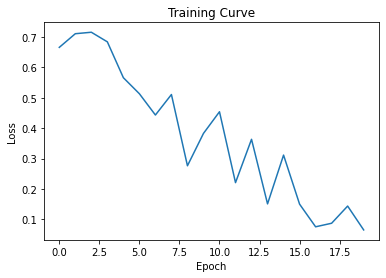

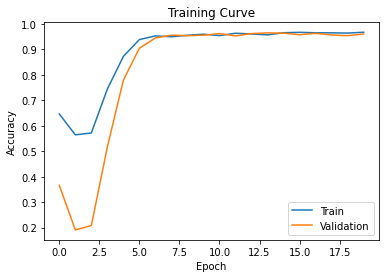

In [ ]:
model_1 = SpamRNN(input_size=len(text_field.vocab), hidden_size=20, num_classes=2)
train_rnn_network(model_1, train, valid, batch_size=32, num_epochs=20, learning_rate=1e-4)

### Part (c)

Choose at least 4 hyperparameters to tune. Explain how you tuned the hyperparameters.
You don't need to include your training curve for every model you trained.
Instead, explain what hyperparemters you tuned, what the best validation accuracy was,
and the reasoning behind the hyperparameter decisions you made.

For this assignment, you should tune more than just your learning rate and epoch. 
Choose at least 2 hyperparameters that are unrelated to the optimizer.

**Answer:**
I tried a batch size of 36, number of epochs to 20, learning rate to 1e-3, and hidden size to 20. However, this led to underfitting and a lot of noise in the graphs.

To fix that, I reduced the batch size to 30, and increased the learning rate to 1e-4. This led to a higher number of iterations, allowing the model's weights to get updated more.

To further increase the validation accuracy, I increased the hidden size to 30. This gave the model more depth/complexity.

Then, I kept all the hyperparameters constant except for one: I tried concatenating the max pooling and average pooling of the RNN outputs. Basically, I used the third provided output from the "Model Building" section. In my scenario, the original output from the sample code (or the second provided output from the "Model Building" section) worked better. 

Batch_size=30, num_epochs=20, learning_rate=1e-4, hidden_size=30, model output to the second provided one from "Part 2: Model Building."

Train accuracy: 98.6%  
Validation accuracy: 97.8%


In [ ]:
#this is my FINAL model

epoch:  0 train acc:  0.5276093724397837 val acc:  0.12286995515695068
epoch:  1 train acc:  0.5276093724397837 val acc:  0.12286995515695068
epoch:  2 train acc:  0.5521874487956743 val acc:  0.18565022421524663
epoch:  3 train acc:  0.864820580042602 val acc:  0.747982062780269
epoch:  4 train acc:  0.9315090938882516 val acc:  0.9147982062780269
epoch:  5 train acc:  0.9298705554645257 val acc:  0.9560538116591928
epoch:  6 train acc:  0.9431427166967066 val acc:  0.9560538116591928
epoch:  7 train acc:  0.9362608553170572 val acc:  0.97847533632287
epoch:  8 train acc:  0.9554317548746518 val acc:  0.9695067264573991
epoch:  9 train acc:  0.9592003932492217 val acc:  0.968609865470852
epoch:  10 train acc:  0.9700147468458136 val acc:  0.9668161434977578
epoch:  11 train acc:  0.9713255775847943 val acc:  0.9650224215246637
epoch:  12 train acc:  0.9646075700475176 val acc:  0.9748878923766816
epoch:  13 train acc:  0.9757496313288546 val acc:  0.9730941704035875
epoch:  14 train a

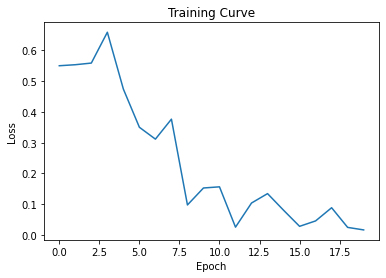

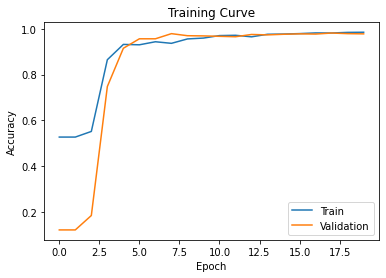

In [ ]:
model_1 = SpamRNN(input_size=len(text_field.vocab), hidden_size=30, num_classes=2)
train_rnn_network(model_1, train, valid, batch_size=30, num_epochs=20, learning_rate=1e-4)

### Part (d)

Before we deploy a machine learning model, we usually want to have a better understanding
of how our model performs beyond its validation accuracy. An important metric to track is
*how well our model performs in certain subsets of the data*.

In particular, what is the model's error rate amongst data with negative labels?
This is called the **false positive rate**.

What about the model's error rate amongst data with positive labels?
This is called the **false negative rate**.

Report your final model's false positive and false negative rate across the
validation set.

In [ ]:
# Create a Dataset of only spam validation examples
valid_spam = torchtext.data.Dataset(
    [e for e in valid.examples if e.label == 1],
    valid.fields)
# Create a Dataset of only non-spam validation examples
valid_nospam = torchtext.data.Dataset(
    [e for e in valid.examples if e.label == 0],
    valid.fields)

In [ ]:
def get_accuracy_2(model, data):
    """ Compute the accuracy of the `model` across a dataset `data`
    
    Example usage:
    
    >>> model = MyRNN() # to be defined
    >>> get_accuracy(model, valid) # the variable `valid` is from above
    """

    data_iter = torchtext.data.BucketIterator(data,
                              batch_size=30,
                              sort_key=lambda x: len(x.sms), # to minimize padding
                              sort_within_batch=True, # sort within each batch
                              repeat=False) # repeat the iterator for many epochs
    correct, total = 0, 0
    for batch in data_iter:
      output = model(batch.sms[0])
      pred = output.max(1, keepdim=True)[1]
      correct += pred.eq(batch.label.view_as(pred)).sum().item()
      total += batch.sms[1].shape[0]
    #Ex for valid_spam: return the number of instances where a non-spam email was 
    #incorrectly labelled as spam (variable: incorrect) divided by the total number of spam 
    #emails
    incorrect=total-correct
    return incorrect/total*100


In [ ]:
#false positive rate

In [ ]:
model_1 = SpamRNN(input_size=len(text_field.vocab), hidden_size=30, num_classes=2)
get_accuracy_2(model_1,valid_spam)

13.636363636363635

In [ ]:
#false negative rate

In [ ]:
model_1 = SpamRNN(input_size=len(text_field.vocab), hidden_size=30, num_classes=2)
get_accuracy_2(model_1,valid_nospam)

5.188199389623601

### Part (e)

The impact of a false positive vs a false negative can be drastically different.
If our spam detection algorithm was deployed on your phone, what is the impact
of a false positive on the phone's user? What is the impact of a false negative?

**Answer:**
A false positive can potentially lead to an important email/SMS being classified as spam, hence being moved to the junk folder or directly getting deleted. The user may miss some important information by not checking his/her junk folder.

A false negative email/SMS could end up in a user's inbox. One impact of this is that it is just annoying to receive and see spam email/SMS. Another more serious impact is that the user may not think the email/SMS is spam, and may go on to click the links, get scammed, etc.

## Part 4. Evaluation

### Part (a)

Report the final test accuracy of your model.

**Answer:**
The test accuracy, as shown below, is 96%.

epoch:  0 train acc:  0.5276093724397837 val acc:  0.12286995515695068
epoch:  1 train acc:  0.5279370801245289 val acc:  0.12286995515695068
epoch:  2 train acc:  0.844994265115517 val acc:  0.7040358744394619
epoch:  3 train acc:  0.9447812551204325 val acc:  0.915695067264574
epoch:  4 train acc:  0.945436670489923 val acc:  0.9219730941704036
epoch:  5 train acc:  0.9349500245780764 val acc:  0.9515695067264573
epoch:  6 train acc:  0.9480583319678847 val acc:  0.9542600896860987
epoch:  7 train acc:  0.9333114861543503 val acc:  0.95695067264574
epoch:  8 train acc:  0.9596919547763395 val acc:  0.9434977578475336
epoch:  9 train acc:  0.9623136162543011 val acc:  0.947085201793722
epoch:  10 train acc:  0.9546124856627888 val acc:  0.9219730941704036
epoch:  11 train acc:  0.9641160085203998 val acc:  0.9381165919282511
epoch:  12 train acc:  0.9434704243814518 val acc:  0.9659192825112107
epoch:  13 train acc:  0.9673930853678518 val acc:  0.9542600896860987
epoch:  14 train acc

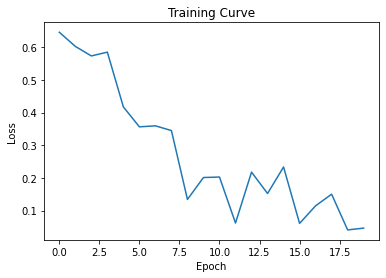

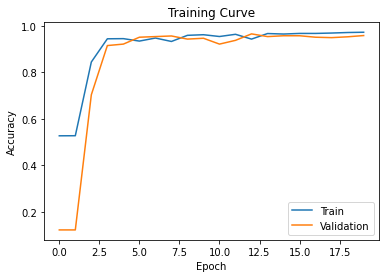

0.9622980251346499

In [ ]:
model_1 = SpamRNN(input_size=len(text_field.vocab), hidden_size=30, num_classes=2)
train_rnn_network(model_1, train, valid, batch_size=30, num_epochs=20, learning_rate=1e-4)
get_accuracy(model_1,test)

### Part (b)

Report the false positive rate and false negative rate of your model across the test set.

In [ ]:
#false positive rate below: 4.219%

epoch:  0 train acc:  0.5381144238517325 val acc:  1.0
epoch:  1 train acc:  0.5896857373086221 val acc:  1.0
epoch:  2 train acc:  0.9452054794520548 val acc:  0.9621212121212122
epoch:  3 train acc:  0.9439161966156325 val acc:  0.9318181818181818
epoch:  4 train acc:  0.9481063658340049 val acc:  0.946969696969697
epoch:  5 train acc:  0.9542304593070104 val acc:  0.9393939393939394
epoch:  6 train acc:  0.9564867042707494 val acc:  0.9318181818181818
epoch:  7 train acc:  0.9492344883158743 val acc:  0.9242424242424242
epoch:  8 train acc:  0.9659951651893635 val acc:  0.9696969696969697
epoch:  9 train acc:  0.9648670427074939 val acc:  0.9393939393939394
epoch:  10 train acc:  0.9572925060435133 val acc:  0.9242424242424242
epoch:  11 train acc:  0.9656728444802578 val acc:  0.9242424242424242
epoch:  12 train acc:  0.9448831587429493 val acc:  0.9090909090909091
epoch:  13 train acc:  0.9734085414987913 val acc:  0.9393939393939394
epoch:  14 train acc:  0.972119258662369 val ac

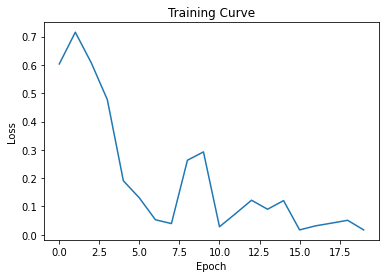

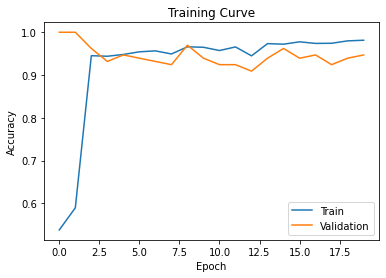

4.21903052064632

In [ ]:
model_1 = SpamRNN(input_size=len(text_field.vocab), hidden_size=30, num_classes=2)
train_rnn_network(model_1, train, valid_spam, batch_size=30, num_epochs=20, learning_rate=1e-4)
get_accuracy_2(model_1,test)

In [ ]:
#false negative rate below: 4.578%

epoch:  0 train acc:  0.5505237711522966 val acc:  0.9969481180061037
epoch:  1 train acc:  0.8897663174858985 val acc:  0.7843336724313327
epoch:  2 train acc:  0.9353746978243352 val acc:  0.8921668362156663
epoch:  3 train acc:  0.9379532634971797 val acc:  0.9521871820956256
epoch:  4 train acc:  0.9408541498791297 val acc:  0.9542217700915565
epoch:  5 train acc:  0.9463336019339242 val acc:  0.9582909460834181
epoch:  6 train acc:  0.9484286865431104 val acc:  0.9613428280773143
epoch:  7 train acc:  0.9519742143432716 val acc:  0.9623601220752798
epoch:  8 train acc:  0.9547139403706688 val acc:  0.9460834181078331
epoch:  9 train acc:  0.9593875906526994 val acc:  0.9521871820956256
epoch:  10 train acc:  0.9605157131345688 val acc:  0.9643947100712106
epoch:  11 train acc:  0.9619661563255439 val acc:  0.9633774160732451
epoch:  12 train acc:  0.9639000805801773 val acc:  0.9694811800610377
epoch:  13 train acc:  0.9708299758259468 val acc:  0.960325534079349
epoch:  14 train 

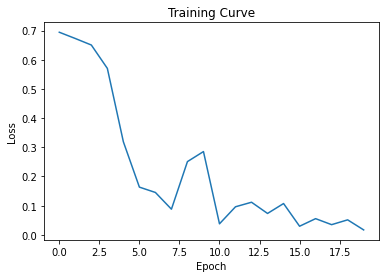

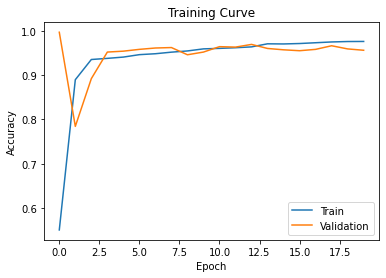

4.578096947935368

In [ ]:
model_1 = SpamRNN(input_size=len(text_field.vocab), hidden_size=30, num_classes=2)
train_rnn_network(model_1, train, valid_nospam, batch_size=30, num_epochs=20, learning_rate=1e-4)
get_accuracy_2(model_1,test)

### Part (c)

What is your model's prediction of the **probability** that
the SMS message "machine learning is sooo cool!" is spam?

Hint: To begin, use `text_field.vocab.stoi` to look up the index
of each character in the vocabulary.

In [ ]:
msg = "machine learning is sooo cool!"
stoi=text_field.vocab.stoi
embed=[]
for i in msg:
  embed.append(stoi[i])

embed=torch.tensor(embed).unsqueeze(0)
model_1 = SpamRNN(input_size=len(text_field.vocab), hidden_size=30, num_classes=2)
pred=model_1(embed)
pred=torch.softmax(pred,dim=1)[0]
pred = pred.max(0, keepdim=True)[1]
print(pred)

tensor([0])


**Answer:**
Because the output of the code above is a tensor with element 0, it means that the model predicts "msg" to be non-spam/ham.

### Part (d)

Do you think detecting spam is an easy or difficult task?

Since machine learning models are expensive to train and deploy, it is very
important to compare our models against baseline models: a simple
model that is easy to build and inexpensive to run that we can compare our
recurrent neural network model against.

Explain how you might build a simple baseline model. This baseline model
can be a simple neural network (with very few weights), a hand-written algorithm,
or any other strategy that is easy to build and test.

**Do not actually build a baseline model. Instead, provide instructions on
how to build it.**

The simple baseline model that I would choose would be Naive Bayes. Naive Bayes can be used to detect spam email/SMS.

1. Import the dataset. From sklearn, import CountVectorizer and MultinomialNB. 
2. Split the dataset into training and testing (validation set is not necessary as there aren't any "hyperparameters" to tune.
3. Use the CountVectorizer() function on the training data to count the number of times each word is used per email. 
4. Using MultinomialNB(), fit the variable from above (which has the number of times each word is used per email) with the actual labels of the emails (i.e. spam or ham). Basically, apply the MultinomialNB() method/algorithm. 
5. The model can be tested on the testing data for knowledge of its accuracy.